# Анализ увольнения сотрудников

**Описание значений параметров датасета**

*   EmployeeID - идентификатор сотрудника.
*   total months of experience - общий стаж сотрудника в месяцах.
*   total organization worked at - общее количество организаций, в которых сотрудник работал на данный момент.
*   months in organization - общее количество месяцев, которые сотрудник проработал в данной организации.
*   last pay increment - последний диапазон повышения заработной платы - это шкала от одного до пяти, где один - самый высокий. Чем выше диапазон, тем выше повышение заработной платы сотрудника в последнем цикле повышения.
*   average feedback - средняя обратная связь, основанная на 360-градусной обратной связи, которую сотрудник получил в ходе оценки результатов работы. Опять же, это шкала от одного до пяти, где один - самая высокая оценка.
*   last promotion year - общее количество лет, прошедших с момента последнего повышения сотрудника.
*   attrition - показывает, покинул ли сотрудник организацию или нет.


# **Подключение используемых библиотек**

In [13]:
# preprocessing 
import pandas as pd
import numpy as np

# visualization 
import seaborn as sns
import matplotlib.pyplot as plt

# datasets, classifiers and performance metrics
from sklearn import datasets, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

Версии используемых пакетов.

In [2]:
for package in [np, pd, tf]:
    print(package.__name__, 'version:', package.__version__)

numpy version: 1.20.3
pandas version: 1.3.4
tensorflow version: 2.8.0


# **Загрузка данных**

In [3]:
df = pd.read_csv('employee_attrition.csv')

In [4]:
df

,EmployeeID,TotalMonthsOfExp,TotalOrgsWorked,MonthsInOrg,LastPayIncrementBand,AverageFeedback,LastPromotionYears,Attrition
0,1,110,4,9,5,4,4,1
1,2,103,3,51,1,4,2,0
2,3,41,4,16,5,4,4,1
3,4,32,4,17,5,2,3,0
4,5,80,3,16,3,4,2,0
...,...,...,...,...,...,...,...,...
995,996,44,1,9,3,1,2,0
996,997,6,2,5,2,1,1,0
997,998,29,3,1,3,4,2,0
998,999,92,2,7,1,2,4,1


In [5]:
print('Размерность данных: количество строк - {0}, количество колонок - {1}'.format(df.shape[0], df.shape[1]))

Размерность данных: количество строк - 1000, количество колонок - 8


## **Визуализация наличия пропусков данных, Проверка дубликатов**

<AxesSubplot:>

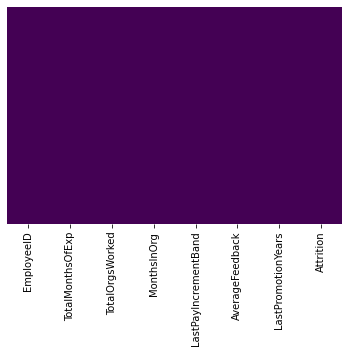

In [8]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   EmployeeID            1000 non-null   int64
 1   TotalMonthsOfExp      1000 non-null   int64
 2   TotalOrgsWorked       1000 non-null   int64
 3   MonthsInOrg           1000 non-null   int64
 4   LastPayIncrementBand  1000 non-null   int64
 5   AverageFeedback       1000 non-null   int64
 6   LastPromotionYears    1000 non-null   int64
 7   Attrition             1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB


**Пропуски данных отсутствуют**

In [10]:
df.duplicated().sum()

0

**Дублирующиеся значения отсутствуют**

## Посмотрим основную статистику.

In [11]:
df.describe()

,EmployeeID,TotalMonthsOfExp,TotalOrgsWorked,MonthsInOrg,LastPayIncrementBand,AverageFeedback,LastPromotionYears,Attrition
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,61.002000,3.056000,31.000000,3.063000,2.539000,2.45400,0.230000
std,288.819436,34.818132,1.398148,26.783341,1.413162,1.143585,1.10413,0.421043
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000,0.000000
25%,250.750000,31.000000,2.000000,9.000000,2.000000,1.000000,1.00000,0.000000
50%,500.500000,61.000000,3.000000,23.000000,3.000000,3.000000,2.00000,0.000000
75%,750.250000,91.250000,4.000000,48.000000,4.000000,4.000000,3.00000,0.000000
max,1000.000000,120.000000,5.000000,116.000000,5.000000,4.000000,4.00000,1.000000


В среднем сотрудники имеют общий опыт работы 5 лет, из которых 2,5 в нашей организации.

Максимальный стаж в организации - 9,5 лет, минимальный - 1 месяц.

Средняя обратная связь распределена почти равномерно.


# **Коэффициент корреляции - Построеное тепловой карты**

<AxesSubplot:title={'center':'Попарная корреляция'}>

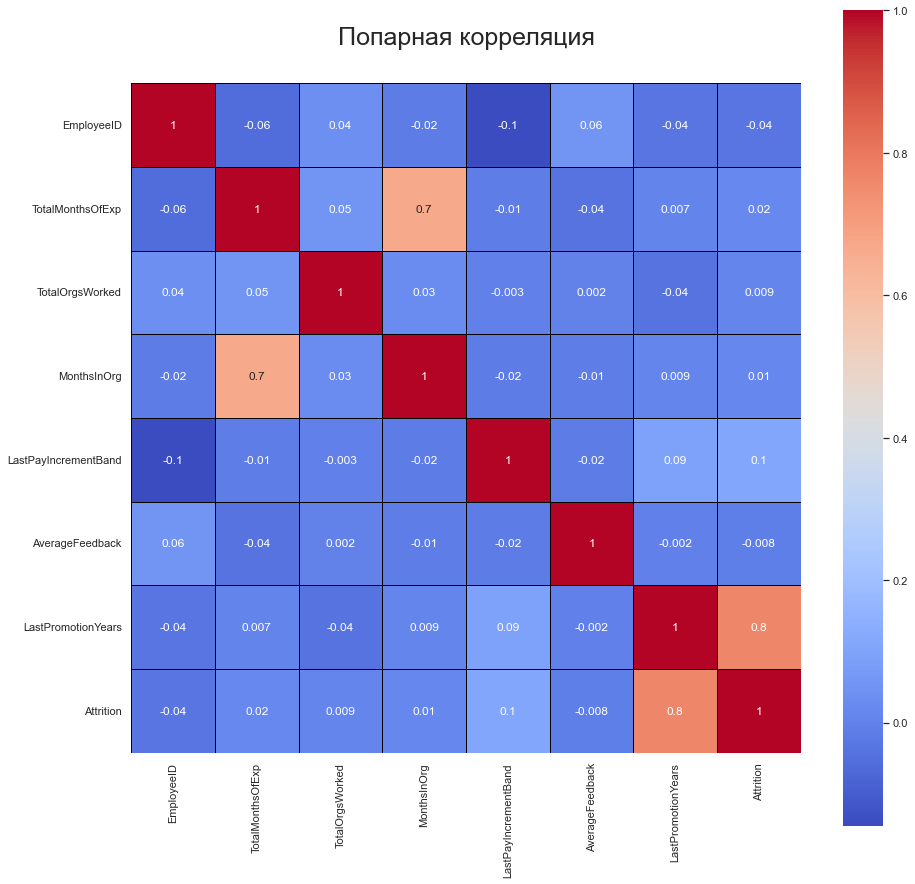

In [16]:
plt.title('Попарная корреляция', y = 1.05, size = 25)
sns.set(rc={"figure.figsize": (15, 15)})
sns.heatmap(df.corr(), annot = True,  fmt='.1g', vmax = 1.0, cmap = 'coolwarm', square= True, linewidths=1, linecolor='black')

Выведем отдельно корреляцию к целевому показетелю Attrition

In [17]:
df.corr()['Attrition']

EmployeeID             -0.036630
TotalMonthsOfExp        0.019702
TotalOrgsWorked         0.008706
MonthsInOrg             0.012605
LastPayIncrementBand    0.108528
AverageFeedback        -0.008253
LastPromotionYears      0.765641
Attrition               1.000000
Name: Attrition, dtype: float64

**Вывод:**
1. Прослеживается зависимость между общим стажем сотрудника и стажем его работы в организации;
2. Параметр LastPromotionYears оказывает значительное влияние на отсев, что означает, что сотрудники уходят, когда не видят достаточного карьерного роста.



# **Построение моделей**

Сохраняем отдельно целевые значения и отдельные данные без целевых значений.

In [6]:
X = df.drop('Attrition', axis = 1)
y = df['Attrition']

## **Построим простые модели**

Разделение датасета на тренировочный (80%) и тестовый (20%) блоки, зададим параметр random_state.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
models = [RandomForestClassifier(), KNeighborsClassifier(), SVC(), LogisticRegression(),xgb.XGBClassifier()]
scores = dict()

for m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)

    print(f'model: {str(m)}')
    print(classification_report(y_test,y_pred, zero_division=1))
    print('-'*60, '\n')

model: RandomForestClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00        48

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

------------------------------------------------------------ 

model: KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       152
           1       0.22      0.10      0.14        48

    accuracy                           0.69       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.63      0.69      0.65       200

------------------------------------------------------------ 

model: SVC()
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       152
           1       1.00      0.00   

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


model: XGBClassifier()
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00        48

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

------------------------------------------------------------ 



**RandomForestClassifier хорошо себя показал.**

In [16]:
model=RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       1.00      1.00      1.00        48

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



**Посмотрим, как распределены веса.**

In [17]:
feature_importances=model.feature_importances_
feature_importances_df=pd.DataFrame({'features':list(X_train), 'feature_importances':feature_importances})
feature_importances_df=pd.DataFrame({'features':list(X_train), 'feature_importances':feature_importances})
feature_importances_df.sort_values('feature_importances',ascending=False)

,features,feature_importances
6,LastPromotionYears,0.898268
0,EmployeeID,0.030719
3,MonthsInOrg,0.022972
1,TotalMonthsOfExp,0.022073
4,LastPayIncrementBand,0.012957
2,TotalOrgsWorked,0.006827
5,AverageFeedback,0.006184


**Как было видно на корреляционной карте, наиболее весомый вклад в решение работника уволиться вносит параметр LastPromotionYears.**

## **Построим нейросеть**

Подготовим данные для работы с Keras.

In [12]:
#Перевод Dataframe в numpy array
np_df = df.to_numpy().astype(float)

#Преобразуем датафрейм в массив
np_df = df.to_numpy().astype(float)

#Разделим данные
X_train = np_df[:,1:7]
Y_train=np_df[:,7]

#Преобразуем Y_train в one-hot-encoding
Y_train = tf.keras.utils.to_categorical(Y_train,2)

print('Размерность X_train: количество строк - {0}, количество колонок - {1}'.format(X_train.shape[0], X_train.shape[1]))
print('Размерность Y_train: количество строк - {0}, количество колонок - {1}'.format(Y_train.shape[0], Y_train.shape[1]))

Размерность X_train: количество строк - 1000, количество колонок - 6
Размерность Y_train: количество строк - 1000, количество колонок - 2


In [13]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

#Гиперпараметры нейросети
EPOCHS=130
BATCH_SIZE=100
VERBOSE=1
NB_CLASSES=2
N_HIDDEN=128
VALIDATION_SPLIT=0.2

#Создание модели
model = tf.keras.models.Sequential()

#Добавим превый скрытый слой
model.add(keras.layers.Dense(N_HIDDEN,
                             input_shape=(6,),
                              name='Dense-Layer-1',
                              activation='relu'))

#Добавим второй скрытый слой
model.add(keras.layers.Dense(N_HIDDEN,
                              name='Dense-Layer-2',
                              activation='relu'))

#Добавим последний слой
model.add(keras.layers.Dense(NB_CLASSES,
                             name='Final',
                             activation='softmax'))

#Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Обучение 
model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

Epoch 1/130
8/8 [==============================] - 1s 32ms/step - loss: 0.8419 - accuracy: 0.6837 - val_loss: 0.8256 - val_accuracy: 0.5050
Epoch 2/130
8/8 [==============================] - 0s 6ms/step - loss: 0.6574 - accuracy: 0.7275 - val_loss: 0.7529 - val_accuracy: 0.5250
Epoch 3/130
8/8 [==============================] - 0s 6ms/step - loss: 0.5909 - accuracy: 0.7400 - val_loss: 0.4859 - val_accuracy: 0.8000
Epoch 4/130
8/8 [==============================] - 0s 7ms/step - loss: 0.4969 - accuracy: 0.8037 - val_loss: 0.4662 - val_accuracy: 0.8100
Epoch 5/130
8/8 [==============================] - 0s 7ms/step - loss: 0.4499 - accuracy: 0.8025 - val_loss: 0.4357 - val_accuracy: 0.8400
Epoch 6/130
8/8 [==============================] - 0s 6ms/step - loss: 0.4191 - accuracy: 0.8163 - val_loss: 0.4061 - val_accuracy: 0.8400
Epoch 7/130
8/8 [==============================] - 0s 7ms/step - loss: 0.3940 - accuracy: 0.8338 - val_loss: 0.3799 - val_accuracy: 0.8400
Epoch 8/130
8/8 [=========

**Модель показывает точность 99,5% на валидационной выборке.**

## Можно спрогнозировать увольнение сотрудника, задав параметры

In [18]:
TotalMonthsOfExp=24
TotalOrgsWorked=4
MonthsInOrg=6
LastPayIncrementBand=2
AverageFeedback=4
LastPromotionYears=1

prediction= np.argmax(model.predict([[TotalMonthsOfExp,
                                  TotalOrgsWorked,
                                  MonthsInOrg,
                                  LastPayIncrementBand,
                                  AverageFeedback,
                                  LastPromotionYears]]), axis=1)
if prediction == 1:
  conclusion = 'Сотрудник скоро уволится'
else:
  conclusion = 'Сотрудник пока будет работать'
print('Прогноз:', conclusion)

Прогноз: Работник пока будет работать
